
# Stack Overflow Developer Survey 2025 - AI Adoption, Models, and Agents

This notebook follows the **CRISP-DM** process: business understanding, data understanding, data preparation, modeling, evaluatio. It analyzes the uploaded `survey_results_public2025.csv` file. The model built is for illustrative purposes. It uses only a handful of categorical features and is **not** optimized.


In [1]:
#Import required python Libraries
import pandas as pd, numpy as np, os, re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

plt.rcParams['figure.dpi']=120

csv_path = 'C:/Users/smatam/OneDrive - Ingredion/Documents/Udacity/Course 2 Project 1 & BlogPost/survey_results_public2025.csv'
df = pd.read_csv(csv_path)
print(df.shape)
df.head(2)


C:\Users\smatam\AppData\Local\Temp\ipykernel_3880\72905350.py:15: DtypeWarning: Columns (56,74,92,97,98,105,109,110,132,162,165) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


(49191, 172)


,ResponseId,MainBranch,Age,EdLevel,Employment,EmploymentAddl,WorkExp,LearnCodeChoose,LearnCode,LearnCodeAI,...,AIAgentOrchestration,AIAgentOrchWrite,AIAgentObserveSecure,AIAgentObsWrite,AIAgentExternal,AIAgentExtWrite,AIHuman,AIOpen,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,25-34 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,"Caring for dependents (children, elderly, etc.)",8.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,Vertex AI,NaN,NaN,NaN,ChatGPT,NaN,When I don’t trust AI’s answers,"Troubleshooting, profiling, debugging",61256.0,10.0
1,2,I am a developer by profession,25-34 years old,"Associate degree (A.A., A.S., etc.)",Employed,NaN,2.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers;When I want to...,All skills. AI is a flop.,104413.0,9.0



## Data Understanding & Cleaning
- We focus on AI-related columns: `AISelect` (usage frequency), `AIModelsHaveWorkedWith`, `AIThreat`, `AIAgents`, `AISent` (sentiment).
- We standardize multi-select columns and bucket free-text choices into consistent categories.


In [2]:
#A function to remove any missing (NaN) values, convert the remaining values to strings, 
#and then splits each string into a list of substrings using a semicolon (;) as the separator

sep=';'

def split_multiselect(series):
    return series.dropna().astype(str).str.split(sep)

# Normalize AI tool usage frequency

def map_ai_usage(v):
    if pd.isna(v):
        return np.nan
    s=str(v).lower()
    if 'daily' in s: return 'Daily'
    if 'weekly' in s: return 'Weekly'
    if 'monthly' in s or 'infrequent' in s or 'less than once' in s: return 'Monthly or less'
    if "don't plan" in s or "don't use" in s: return 'Do not use'
    return 'Other'

ai_usage = df['AISelect'].map(map_ai_usage)
ai_usage.value_counts(dropna=True)


Daily              15883
Weekly              5958
Do not use          5454
Monthly or less     4628
Other               1797
Name: AISelect, dtype: int64


## Exploratory Analysis (EDA)
### 1) How often do developers use AI tools?


Daily              15883
Weekly              5958
Monthly or less     4628
Do not use          5454
Other               1797
Name: AISelect, dtype: int64

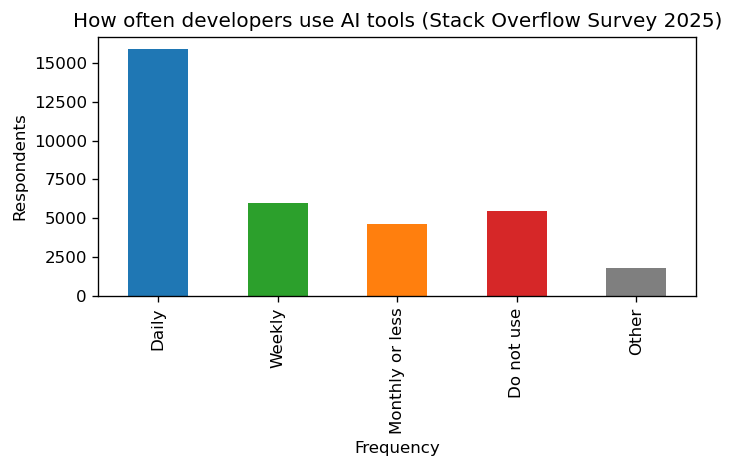

In [3]:
ai_usage_dist = ai_usage.value_counts().reindex(['Daily','Weekly','Monthly or less','Do not use','Other']).dropna()
ax = ai_usage_dist.plot(kind='bar', color=['#1f77b4','#2ca02c','#ff7f0e','#d62728','#7f7f7f'])
ax.set_title('How often developers use AI tools (Stack Overflow Survey 2025)')
ax.set_ylabel('Respondents')
ax.set_xlabel('Frequency')
plt.tight_layout();
plt.savefig('figs/ai_usage_distribution.png', dpi=200)
ai_usage_dist



### 2) What AI models/tools are most used?


In [4]:
models_used = split_multiselect(df['AIModelsHaveWorkedWith'])
from collections import Counter
model_counts = Counter([m.strip() for lst in models_used for m in lst if isinstance(m,str) and m.strip()])
import pandas as pd

pd.Series(model_counts).sort_values(ascending=False).head(12)


openAI GPT (chatbot models)              13424
Anthropic: Claude Sonnet                  7063
Gemini (Flash general purpose models)     5823
openAI Reasoning models                   5716
openAI Image generating models            4395
Gemini (Pro Reasoning models)             4221
DeepSeek (R- Reasoning models)            3848
Meta Llama (all models)                   2941
DeepSeek (V- General purpose models)      2363
X Grok models                             1839
Mistral AI models                         1712
Perplexity Sonar models                   1250
dtype: int64

openAI GPT (chatbot models)              13424
Anthropic: Claude Sonnet                  7063
Gemini (Flash general purpose models)     5823
openAI Reasoning models                   5716
openAI Image generating models            4395
Gemini (Pro Reasoning models)             4221
DeepSeek (R- Reasoning models)            3848
Meta Llama (all models)                   2941
DeepSeek (V- General purpose models)      2363
X Grok models                             1839
Mistral AI models                         1712
Perplexity Sonar models                   1250
dtype: int64

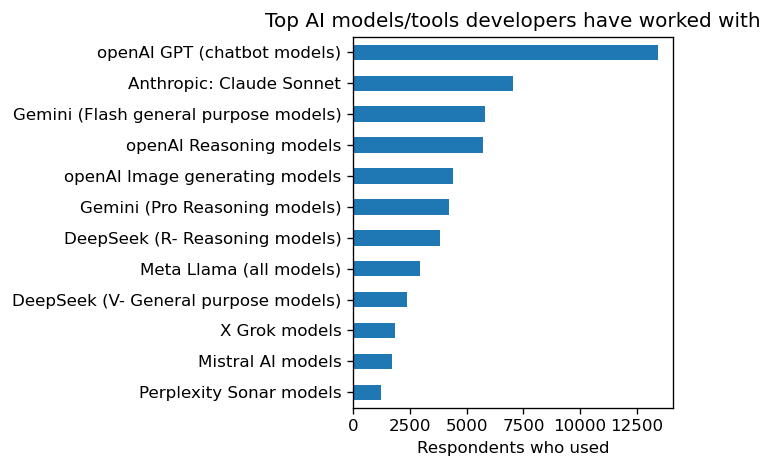

In [5]:
# Plot top 12
import pandas as pd
_top = pd.Series(model_counts).sort_values(ascending=False).head(12)
ax = _top.sort_values().plot(kind='barh', color='#1f77b4')
ax.set_title('Top AI models/tools developers have worked with')
ax.set_xlabel('Respondents who used')
plt.tight_layout();
plt.savefig('figs/top_ai_models_used.png', dpi=200)
_top



### 3) Do developers see AI as a threat to their job?


No        22958
Unsure     7700
Yes        5420
Name: AIThreat, dtype: int64

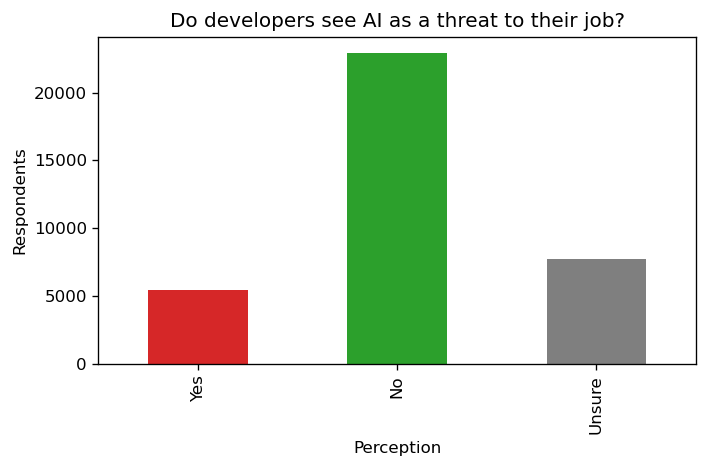

In [6]:
def norm_threat(v):
    if pd.isna(v): return np.nan
    s=str(v).strip().lower()
    if s in ['yes','yeah','y','yes it is','yes, definitely','yes, somewhat','yes to a great extent','yes its a threat','partly']:
        return 'Yes'
    if s in ['no','no it isnt','no, not really','no it is not','not at all']:
        return 'No'
    if 'not sure' in s or "i'm not sure" in s or 'unsure' in s:
        return 'Unsure'
    if 'somewhat' in s or 'part' in s:
        return 'Somewhat'
    return 'Other'

threat = df['AIThreat'].map(norm_threat)
threat_dist = threat.value_counts()
ax = threat_dist.reindex(['Yes','No','Unsure','Somewhat','Other']).dropna().plot(kind='bar', color=['#d62728','#2ca02c','#7f7f7f','#ff7f0e','#1f77b4'])
ax.set_title('Do developers see AI as a threat to their job?')
ax.set_ylabel('Respondents')
ax.set_xlabel('Perception')
plt.tight_layout();
plt.savefig('figs/ai_threat_perception.png', dpi=200)
threat_dist



### 4) AI agent adoption at work


In [7]:
def map_agent(v):
    if pd.isna(v): return np.nan
    s=str(v).lower()
    if 'daily' in s: return 'Daily'
    if 'weekly' in s: return 'Weekly'
    if 'monthly' in s or 'infrequent' in s or 'less than once' in s: return 'Monthly or less'
    if 'no, but i plan' in s: return 'Plan to start'
    if "no, and i don't plan" in s: return 'Do not plan'
    return 'Other'

agent_bucket = df['AIAgents'].map(map_agent)
agent_bucket.value_counts().reindex(['Daily','Weekly','Monthly or less','Plan to start','Do not plan','Other']).dropna()


Daily               4509
Weekly              2868
Monthly or less     2498
Plan to start       5561
Do not plan        12082
Other               4401
Name: AIAgents, dtype: int64

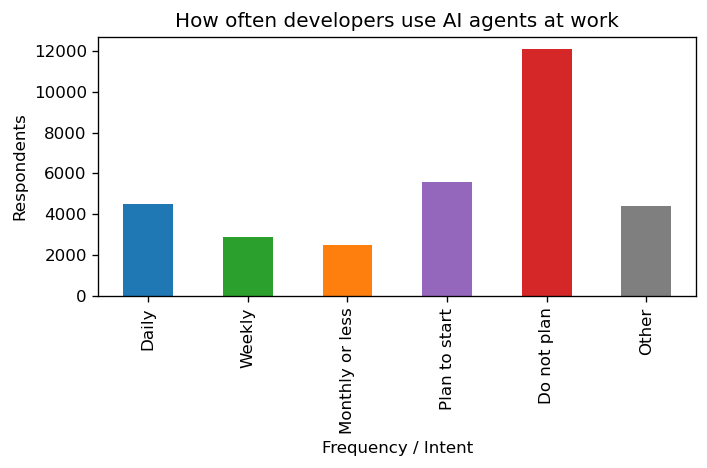

In [8]:
ax = agent_bucket.value_counts().reindex(['Daily','Weekly','Monthly or less','Plan to start','Do not plan','Other']).dropna().plot(kind='bar', color=['#1f77b4','#2ca02c','#ff7f0e','#9467bd','#d62728','#7f7f7f'])
ax.set_title('How often developers use AI agents at work')
ax.set_ylabel('Respondents')
ax.set_xlabel('Frequency / Intent')
plt.tight_layout();
plt.savefig('figs/ai_agent_adoption.png', dpi=200)



### 5) Overall sentiment toward AI tools


Favorable           12311
Very favorable       7677
Indifferent          5880
Unfavorable          3621
Very unfavorable     3219
Unsure                759
Name: AISent, dtype: int64

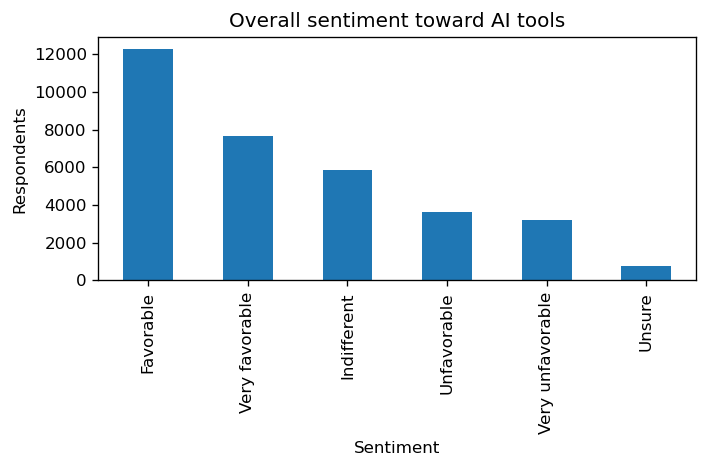

In [9]:
sent = df['AISent'].dropna().value_counts()
ax = sent.plot(kind='bar', color='#1f77b4')
ax.set_title('Overall sentiment toward AI tools')
ax.set_ylabel('Respondents')
ax.set_xlabel('Sentiment')
plt.tight_layout();
plt.savefig('figs/ai_sentiment.png', dpi=200)
sent



## Modeling: Predicting Daily/Weekly AI Tool Usage
We build a logistic regression model to predict whether a respondent is a **daily/weekly** AI user from non-technical demographics: `Age`, `DevType`, `OrgSize`, `RemoteWork`, and `Country`.


In [10]:
label = ai_usage.isin(['Daily','Weekly']).astype(float).replace({np.nan: np.nan})
X = df[['Age','DevType','OrgSize','RemoteWork','Country']].copy()
mask = label.notna() & X.notna().all(axis=1)
X2, y2 = X[mask], label[mask].astype(int)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', min_frequency=50), list(X2.columns))
])

clf = Pipeline([
    ('pre', pre),
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

Xtr, Xte, ytr, yte = train_test_split(X2, y2, test_size=0.25, random_state=42, stratify=y2)
clf.fit(Xtr, ytr)
yp = clf.predict(Xte)
yp_proba = clf.predict_proba(Xte)[:,1]
acc = accuracy_score(yte, yp)
prec, rec, f1, _ = precision_recall_fscore_support(yte, yp, average='binary', zero_division=0)
auc = roc_auc_score(yte, yp_proba)
acc, prec, rec, f1, auc


(0.5920900692840647,
 0.7055007784120394,
 0.6165532879818594,
 0.6580348499515973,
 0.6275262103782472)


## Scenario (Deployment):
**Persona**: A back-end developer, age 25–34, in a 100–499 employee company, hybrid work, based in the United States.

We estimate the probability that this persona is a **daily/weekly AI user**.


In [11]:
scenario = pd.DataFrame({
    'Age':['25-34 years old'],
    'DevType':['Developer, back-end'],
    'OrgSize':['100 to 499 employees'],
    'RemoteWork':['Hybrid (some in-person, leans heavy to flexibility)'],
    'Country':['United States of America']
})
clf.predict_proba(scenario)[:,1][0]


0.46083513941086496